<a href="https://colab.research.google.com/github/Rasi2697/Analyis-and-Prediction-of-Student-Performance/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis and Prediction of Student Performance based on class reports

The purpose of this analysis is to provide a method for early identification of students at risk of failing. 

* Installing required packages.

In [ ]:
!pip install missingno
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Required packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from plotnine import *
import missingno as msno
import seaborn as sns
import plotly.express as px
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from random import randint
from scipy.stats import randint
import seaborn as sns


* Importing data from Google Drive.

In [ ]:
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Reading the datasets and cleaning the data.

In [ ]:
course = pd.read_csv("/content/drive/MyDrive/Rasi Final Project Data/courses.csv")
assesment = pd.read_csv("/content/drive/MyDrive/Rasi Final Project Data/assessments.csv")
vle = pd.read_csv("/content/drive/MyDrive/Rasi Final Project Data/vle.csv")
info_stu = pd.read_csv("/content/drive/MyDrive/Rasi Final Project Data/studentInfo.csv")
reg_stu = pd.read_csv("/content/drive/MyDrive/Rasi Final Project Data/studentRegistration.csv")
ass_stu = pd.read_csv("/content/drive/MyDrive/Rasi Final Project Data/studentAssessment.csv")
vle_stu = pd.read_csv("/content/drive/MyDrive/Rasi Final Project Data/studentVle.csv")

In [ ]:
# Code module and code presentation are always used together to identify a module. 
# Therefore, these 2 columns will be merged to create a feature which uniquely identifies a module.

course["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), course.code_module, course.code_presentation))
assesment["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), assesment.code_module, assesment.code_presentation))
vle["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), vle.code_module, vle.code_presentation))
info_stu["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), info_stu.code_module, info_stu.code_presentation))
reg_stu["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), reg_stu.code_module, reg_stu.code_presentation))
vle_stu["module_presentation"] = list(map(lambda x,y: str(x) + "_" + str(y), vle_stu.code_module, vle_stu.code_presentation))


print(" In Student Info table; \n # of rows: {} \n # of unique student Ids: {} \n \
Hence, There are different records for same students' different modul enrolments." .format(len(info_stu),len(info_stu.id_student.unique())))
print("\n This also means that student ID is not really a unique identifier of the table.\n")

 In Student Info table; 
 # of rows: 32593 
 # of unique student Ids: 28785 
 Hence, There are different records for same students' different modul enrolments.

 This also means that student ID is not really a unique identifier of the table.



# **Data Cleaning**

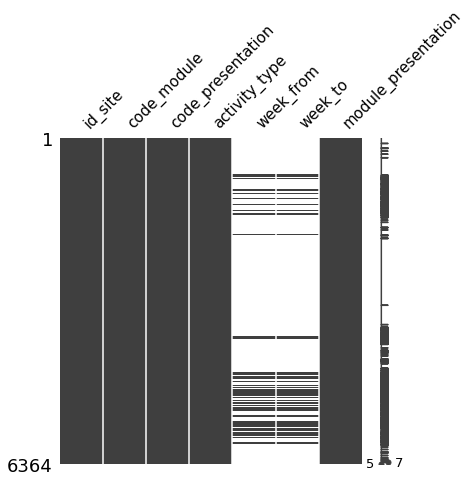

In [ ]:
# Missing values plot for vle 
msno.matrix(vle, figsize=(6,6), fontsize=15)

Most of the entries of 'week_from' and 'week_to' are missing so the analysis will not be focusing on the dates and these columns will be dropped in the next step.

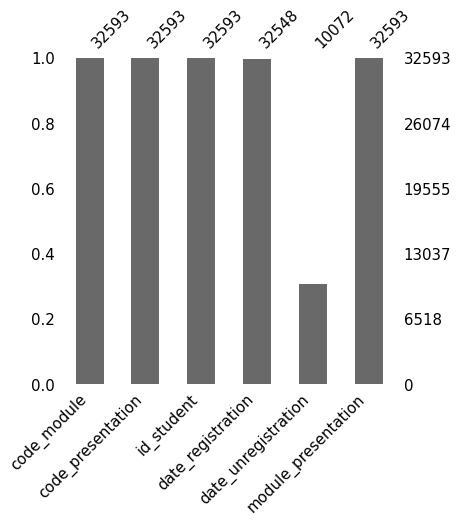

In [ ]:
vle.drop(columns=['week_from','week_to'],inplace=True)
msno.bar(reg_stu, figsize=(6,6), fontsize=15)

Nearly 70% of the rows are missing date_unregistration so the withdrawal rate is low.

In [ ]:
#Find unregistered students according to registration table. 
#Then check whether they are consistent with the final results at StudentInfo table. 
#If a student is unregistered, final result must be recorded as "Withdrawn".


#Select unregistered students according to registration table
temp = reg_stu.loc[reg_stu.date_unregistration.notna(),\
                               ['id_student','module_presentation','date_unregistration']]

# Join to see matching rows
temp =pd.merge(info_stu, temp, on=['id_student','module_presentation'])

# Unregistered students without a "Withdrawn" in final result column 
# Semantic Error -- If a student unregistered, have to have "Withdrawn" as final result! 
wrong_final_results=temp.loc[temp.final_result!='Withdrawn']
incorrect_final_results=wrong_final_results.index
wrong_final_results

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation,date_unregistration
719,BBB,2013J,362907,F,South West Region,Lower Than A Level,20-30%,35-55,2,60,N,Fail,BBB_2013J,0.0
724,BBB,2013J,365288,F,South Region,A Level or Equivalent,70-80%,0-35,0,60,N,Fail,BBB_2013J,0.0
869,BBB,2013J,554243,F,South West Region,Lower Than A Level,60-70%,0-35,0,60,N,Fail,BBB_2013J,166.0
4961,DDD,2013J,315082,M,West Midlands Region,A Level or Equivalent,50-60%,0-35,0,60,N,Fail,DDD_2013J,0.0
5010,DDD,2013J,403052,F,Yorkshire Region,HE Qualification,20-30%,0-35,0,150,N,Fail,DDD_2013J,0.0
5293,DDD,2013J,582954,M,London Region,Lower Than A Level,10-20,0-35,0,120,N,Fail,DDD_2013J,-7.0
7853,FFF,2013J,234004,M,Yorkshire Region,A Level or Equivalent,50-60%,0-35,0,60,N,Fail,FFF_2013J,0.0
8001,FFF,2013J,523777,M,North Region,A Level or Equivalent,0-10%,35-55,1,60,N,Fail,FFF_2013J,0.0
8340,FFF,2013J,601640,M,London Region,HE Qualification,20-30%,0-35,0,90,N,Fail,FFF_2013J,-4.0


* 8 of these 9 students unregistered at the first day of the module presentation or earlier (by looking date_unregistration column), this may be a cause for that inconsistency.
* This also makes a "Fail" impossible as a final result so the above 9 records' final_result entry will be changed into Withdrawn in the next step.

In [ ]:
# Correction info_stu table's final_result entries
for i in wrong_final_results[['id_student','code_module','code_presentation']].values:
    info_stu.loc[(info_stu.id_student==i[0])&(info_stu.code_module==i[1])&\
                 (info_stu.code_presentation==i[2]),'final_result'] = 'Withdrawn'

In [ ]:
assesment.groupby(['code_module','code_presentation']).agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation              
AAA         2013J                     200.0
            2014J                     200.0
BBB         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
CCC         2014B                     300.0
            2014J                     300.0
DDD         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
EEE         2013J                     200.0
            2014B                     200.0
            2014J                     200.0
FFF         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
GGG         2013J                     100.0
            2014B                     100.0
            2014J                     100.0

We can see that CCC with 300 and GGG with 100 weights have some inconsistencies.

In [ ]:
assesment[assesment.code_module.isin(["CCC","GGG"])]\
.groupby(['code_module','code_presentation',"assessment_type"]).agg(type_weights = ('weight',sum))

type_weights
code_module code_presentation assessment_type              
CCC         2014B             CMA                      25.0
                              Exam                    200.0
                              TMA                      75.0
            2014J             CMA                      25.0
                              Exam                    200.0
                              TMA                      75.0
GGG         2013J             CMA                       0.0
                              Exam                    100.0
                              TMA                       0.0
            2014B             CMA                       0.0
                              Exam                    100.0
                              TMA                       0.0
            2014J             CMA                       0.0
                              Exam                    100.0
                              TMA                       0.0

* Module CCC has exam weight as 200 but it should be 100 which will be modified.
* Module GGG doesn't have any CMA and TMA values so that should be corrected.

In [ ]:
# Weights of exams are halved for module CCC
assesment.loc[(assesment.code_module=='CCC') &(assesment.assessment_type=='Exam'),'weight'] = \
assesment.loc[(assesment.code_module=='CCC') &(assesment.assessment_type=='Exam'),'weight']/2

# Weights of TMA and CMA type assessments arranged to be %100.
assesment.loc[(assesment.code_module=='GGG') & (assesment.assessment_type=='TMA'),'weight']=(100/3)

In [ ]:
# Lets check the final assesment table with their weights
assesment.groupby(['code_module','code_presentation']).agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation              
AAA         2013J                     200.0
            2014J                     200.0
BBB         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
CCC         2014B                     200.0
            2014J                     200.0
DDD         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
EEE         2013J                     200.0
            2014B                     200.0
            2014J                     200.0
FFF         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
GGG         2013J                     200.0
            2014B                     200.0
            2014J                     200.0

# **Data Exploration**

### Analysis based on Course Modules

In [ ]:
# Percentage of students in each course module
module = info_stu.groupby('code_module').agg({'id_student':'count'}).reset_index().\
    rename(columns={"code_module": "Module", "id_student": "Qty"})

module['Percentage'] = module.apply(lambda x: round(100 * (x['Qty'] / module['Qty'].sum()),2), axis=1)
    
fig = px.bar(module, x='Module', y='Qty', \
    text='Percentage', color='Module',  hover_data=['Qty'],\
        template="seaborn")

fig.update_layout(
    margin=dict(l=20, r=50, t=50, b=20),
    title = 'Distribution - Module Graph',
    xaxis_title="Module Graph",
    yaxis_title="Quantity [Students]",
    legend_title="Module Graph",
    width=600, 
    height=400,
    uniformtext_minsize=10, 
    uniformtext_mode='hide',
)
fig

In [ ]:
# Percentage of Students Results in each course module
df = info_stu.groupby(['code_module', 'final_result']).agg({'id_student':'count'}).reset_index().\
    rename(columns={"code_module": "Module", "final_result": "Result","id_student": "Qty"})

df['Percentage'] = df.apply(lambda x:  round(100 * (x['Qty'] / df[df['Result'] == x['Result']]['Qty'].sum()),2), axis=1)

fig = px.bar(df, x="Result", y="Percentage", text="Percentage", color="Module",
            hover_data=['Percentage'], barmode = 'stack', template="seaborn")

fig.update_layout(
    margin=dict(l=20, r=50, t=50, b=20),
    title = 'Results by Module Graph',
    xaxis_title="Results",
    yaxis_title="Percentage [%]",
    legend_title="Module Graph",
    width=700, 
    height=500,
    uniformtext_minsize=9, 
    uniformtext_mode='hide',
)
fig


### Analysis on Semester wise performance

In [ ]:
# Percentage of Students in each semester
period = info_stu.groupby('code_presentation').agg({'id_student':'count'}).reset_index().\
    rename(columns={"code_presentation": "Period", "id_student": "Qty"})

period['Percentage'] = period.apply(lambda x: round(100 * (x['Qty'] / period['Qty'].sum()),2), axis=1)
    
fig = px.bar(period, x='Period', y='Qty', \
    text='Percentage', color='Period',  hover_data=['Qty'],\
        template="seaborn")

fig.update_layout(
    margin=dict(l=20, r=50, t=50, b=20),
    title = 'Distribution - Semester Wise Graph',
    xaxis_title="Semester Graph",
    yaxis_title="Quantity [Students]",
    legend_title="Semester Graph",
    width=600, 
    height=400,
    uniformtext_minsize=10, 
    uniformtext_mode='hide',
)
fig.show()


In [ ]:
# Percentage of students Results in each semester 
df = info_stu.groupby(['code_presentation', 'final_result']).agg({'id_student':'count'}).reset_index().\
    rename(columns={"code_presentation": "Period", "final_result": "Result","id_student": "Qty"})

df['Percentage'] = df.apply(lambda x:  round(100 * (x['Qty'] / df[df['Result'] == x['Result']]['Qty'].sum()),2), axis=1)

fig = px.bar(df, x="Result", y="Percentage", text="Percentage", color="Period",
            hover_data=['Percentage'], barmode = 'stack', template="seaborn")

fig.update_layout(
    margin=dict(l=20, r=50, t=50, b=20),
    title = 'Results by Semester Graph',
    xaxis_title="Results",
    yaxis_title="Percentage [%]",
    legend_title="Semester Graph",
    width=700, 
    height=500,
    uniformtext_minsize=9, 
    uniformtext_mode='hide',
)
fig.show()

### Student Analysis on Time Spent in Courses

In [ ]:
# function for merging 2 pandas dataframes

def inner_merge(left_ass_stu,right_ass_stu,right_cols,on_cols):
    right_ass_stu = right_ass_stu[right_cols]
    left_ass_stu = left_ass_stu.merge(right_ass_stu, on = on_cols)
    return left_ass_stu.drop_duplicates()

We want to predict a student's final result based on their early performance. By performance, we mean 2 things: academic performance, measured via the students' scores, and academic engagement, measured via the number of times the students click on course content. The three variables below control how many days into a semester we want to include for our analysis.

In [ ]:
score_deadline = 90
click_deadline = 90
withdraw_deadline = 90

Below we have a function that creates a dataset that contains each student's average assignment score within the first score_deadline days. Another function to create a dataset that contains each student's average number of clicks for each resource category within the first click_deadline days. Then a function to merge the two datasets together, as well as remove students who withdrew before withdraw_deadline. Since our analysis only concerns with Pass/Fail, we merge Distinction final results into Pass, and merge Withdrawn into Fail. The idea is that after a certain amount of time, the only people who withdraw are the people who are concerned with their performance, and are less likely to withdraw due to non-academic related reasons.

In [ ]:
# score data

def create_score_df(score_deadline):

    df1 = assesment
    df2 = ass_stu

    score_df = inner_merge(df1,
                           df2,
                           df2.columns,
                           ['id_assessment'],
                          )

    score_df = score_df[score_df['date'] < score_deadline]
    
    score_df = score_df[score_df['assessment_type'] != 'Exam']

    score_df = score_df.dropna(subset = ['score']) 

    score_df.isnull().sum()

    score_df['assessment_type'].value_counts()

    score_df = score_df.groupby(['code_module', 'code_presentation', 'id_student']).mean().reset_index()
    score_df = score_df.rename(columns = {'score': f'mean_score_day{score_deadline}'})
    score_df = score_df.drop(['date', 'weight', 
                              'date_submitted', 'is_banked',
                              'id_assessment'],
                             axis = 1)
    return score_df


In [ ]:
# click data

def create_click_df(click_deadline):

    clicks = vle_stu

    clicks = inner_merge(clicks,
                         vle,
                         ['id_site','code_module','code_presentation','activity_type'],
                         ['id_site','code_module','code_presentation'],
                        )

    clicks = clicks.drop('id_site', axis = 1)

    def clicks_xx(clicks,xx):
        temp = clicks[clicks['date'] <= xx]
        temp = temp.drop('date', axis = 1)
        temp = temp.groupby(['code_module','code_presentation','id_student','activity_type']).mean()
        temp = temp.rename(columns = {'sum_click': f'sum_click{xx} mean'})
        temp = temp.reset_index() # this fills out the missing columns for merging later 
        return temp
    
    click_data = pd.pivot_table(data = clicks_xx(clicks,click_deadline), 
                                index = ['code_module','code_presentation','id_student'],
                                columns = 'activity_type', 
                                values = [f'sum_click{click_deadline} mean'],
                                fill_value = 0,
                               ).reset_index()

    # get rid of multi index
    click_data = pd.concat([click_data['code_module'],
                            click_data['code_presentation'],
                            click_data['id_student'], 
                            click_data[f'sum_click{click_deadline} mean']], axis=1)
    return click_data



In [ ]:
# merge score_df and click_df
def create_final_df(withdraw_deadline, score_df, click_df):

    final_df = inner_merge(click_df, # merge with StudentInfo
                           info_stu,
                           info_stu.columns,
                           ['code_module', 'code_presentation', 'id_student'],
                          )

    final_df = final_df.replace('Distinction','Pass') # merge Pass and Distinction

    final_df = inner_merge(final_df, 
                           reg_stu,
                           ['code_module', 'code_presentation', 'id_student', 'date_unregistration'],
                           ['code_module', 'code_presentation', 'id_student'],
                          )
    
    final_df = final_df[(final_df['final_result'] != 'Withdrawn') | # remove people who withdrew before withdraw_deadline
                       (final_df['date_unregistration'] > withdraw_deadline)]

    final_df = final_df.reset_index()

    final_df = final_df.drop(['date_unregistration','index'],axis = 1)

    final_df = inner_merge(final_df,
                           score_df,
                           score_df.columns,
                           ['code_module', 'code_presentation', 'id_student'])
    
    final_df = final_df.replace('Withdrawn','Fail') # merge Withdrawn to Fail


    return final_df



In [ ]:
score_df = create_score_df(score_deadline)
click_df = create_click_df(click_deadline)
final_df = create_final_df(withdraw_deadline, score_df, click_df)
final_df.head()

,code_module,code_presentation,id_student,dataplus,forumng,glossary,homepage,oucollaborate,oucontent,ouelluminate,...,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation,mean_score_day90
0,AAA,2013J,11391,0.0,3.514286,0.0,3.478261,0.0,10.235294,0.0,...,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,AAA_2013J,81.5
1,AAA,2013J,28400,0.0,2.988889,0.0,5.194444,0.0,5.636364,0.0,...,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,AAA_2013J,69.0
2,AAA,2013J,31604,0.0,2.955882,1.0,4.340000,0.0,4.910256,0.0,...,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,AAA_2013J,71.5
3,AAA,2013J,32885,0.0,3.127660,2.0,3.600000,0.0,5.303030,0.0,...,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,AAA_2013J,49.5
4,AAA,2013J,38053,7.0,3.457364,0.0,4.438596,0.0,4.230769,0.0,...,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,AAA_2013J,74.0


In [ ]:
final_df = final_df.drop(['code_module', 'code_presentation', 'final_result','id_student','imd_band','module_presentation'],axis = 1)
final_df.columns

Index(['dataplus', 'forumng', 'glossary', 'homepage', 'oucollaborate',
       'oucontent', 'ouelluminate', 'quiz', 'resource', 'sharedsubpage',
       'subpage', 'url', 'gender', 'region', 'highest_education', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'mean_score_day90'],
      dtype='object')

In [ ]:
#all_columns = final_df.columns
##y = 'mean_score_day90'
#feature_columns = all_columns.remove('mean_score_day90')

df = pd.get_dummies(final_df)
df.head()

,dataplus,forumng,glossary,homepage,oucollaborate,oucontent,ouelluminate,quiz,resource,sharedsubpage,...,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,0.0,3.514286,0.0,3.478261,0.0,10.235294,0.0,0.0,1.285714,0.0,...,0,1,0,0,0,0,0,1,1,0
1,0.0,2.988889,0.0,5.194444,0.0,5.636364,0.0,0.0,1.000000,0.0,...,0,1,0,0,0,0,1,0,1,0
2,0.0,2.955882,1.0,4.340000,0.0,4.910256,0.0,0.0,1.666667,0.0,...,1,0,0,0,0,0,1,0,1,0
3,0.0,3.127660,2.0,3.600000,0.0,5.303030,0.0,0.0,1.000000,0.0,...,0,0,1,0,0,1,0,0,1,0
4,7.0,3.457364,0.0,4.438596,0.0,4.230769,0.0,0.0,1.500000,0.0,...,1,0,0,0,0,0,1,0,1,0


In [ ]:
df.columns

Index(['dataplus', 'forumng', 'glossary', 'homepage', 'oucollaborate',
       'oucontent', 'ouelluminate', 'quiz', 'resource', 'sharedsubpage',
       'subpage', 'url', 'num_of_prev_attempts', 'studied_credits',
       'mean_score_day90', 'gender_F', 'gender_M',
       'region_East Anglian Region', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'age_band_0-35',
       'age_band_35-55', 'age_band_55<=', 'disability_N', 'disability_Y'],
      dtype='object')

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
feature_df = df[['dataplus', 'forumng', 'glossary', 'homepage', 'oucollaborate',
       'oucontent', 'ouelluminate', 'quiz', 'resource', 'sharedsubpage',
       'subpage', 'url', 'num_of_prev_attempts', 'studied_credits',
       'gender_F', 'gender_M',
       'region_East Anglian Region', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'age_band_0-35',
       'age_band_35-55', 'age_band_55<=', 'disability_N', 'disability_Y']]

train_features, test_features, train_labels, test_labels = train_test_split(feature_df, df['mean_score_day90'], test_size = 0.25, random_state = 42)

# **Modeling**

### Random Forest Regressor

Here I want to compare 3 different regression models and see which model has lowest mean squared error.

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(rf_predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 11.78


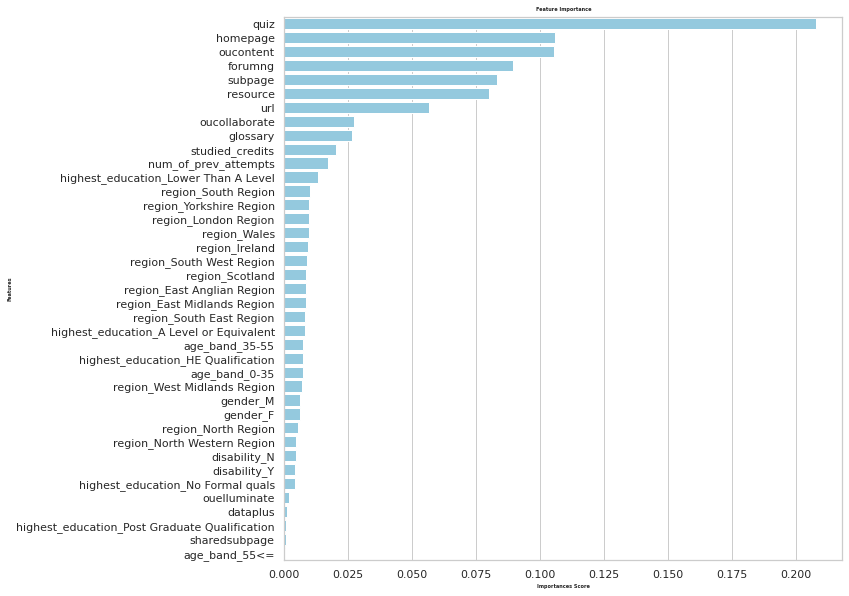

None

In [ ]:
feats = {}

for feature, importance in zip(train_features, rf.feature_importances_):
  feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style='whitegrid', color_codes = True, font_scale = 1)
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importances Score', fontsize=5, weight='bold')
plt.ylabel('Features', fontsize=5, weight='bold')
plt.title('Feature Importance', fontsize=5, weight='bold')
display(plt.show())

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_features, train_labels)

LinearRegression()

In [ ]:
# Use the forest's predict method on the test data
lr_predictions = lr.predict(test_features)
# Calculate the absolute errors
errors = abs(lr_predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 13.03


GradientBoost Regresser

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=600, 
    max_depth=5, 
    learning_rate=0.01, 
    min_samples_split=3)
# with default parameters
gbr = GradientBoostingRegressor()

gbr.fit(train_features, train_labels)


GradientBoostingRegressor()

In [ ]:
# Use the forest's predict method on the test data
gbr_predictions = gbr.predict(test_features)
# Calculate the absolute errors
errors = abs(gbr_predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 11.8


### Feature Importance

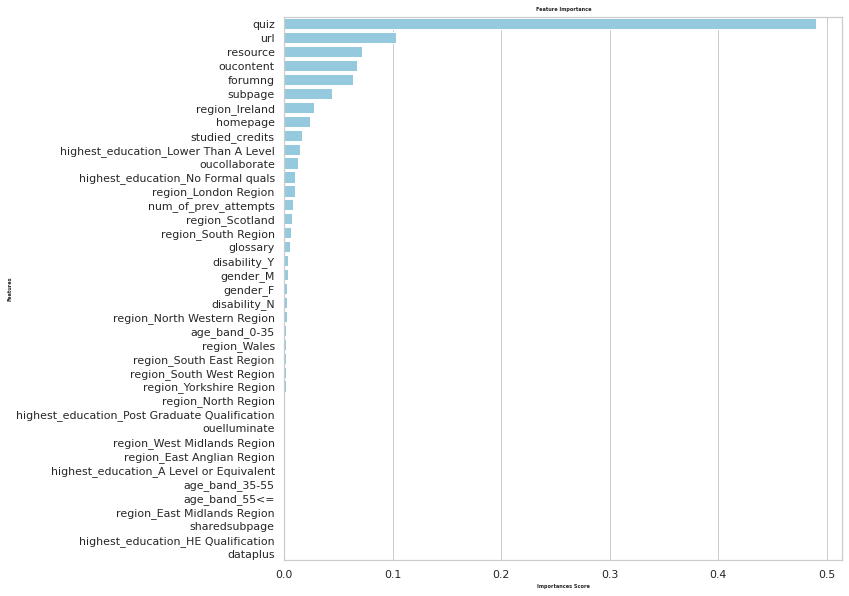

None

In [ ]:
feats = {}

for feature, importance in zip(train_features, gbr.feature_importances_):
  feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style='whitegrid', color_codes = True, font_scale = 1)
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importances Score', fontsize=5, weight='bold')
plt.ylabel('Features', fontsize=5, weight='bold')
plt.title('Feature Importance', fontsize=5, weight='bold')
display(plt.show())

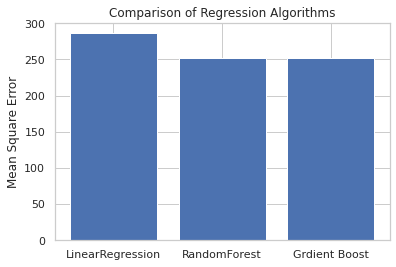

In [ ]:
from sklearn import metrics
y = np.array([metrics.mean_squared_error(test_labels,lr_predictions),metrics.mean_squared_error(test_labels,rf_predictions),
           metrics.mean_squared_error(test_labels,gbr_predictions)])
x = ["LinearRegression","RandomForest","Grdient Boost"]
plt.bar(x,y)
plt.title("Comparison of Regression Algorithms")
plt.ylabel("Mean Square Error")
plt.show()

We can see that Linear Regression has highest mean square error. We can any model between Random and Gradient as both are almost same.